In [5]:
import os
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time

In [6]:
net = cv.dnn.readNetFromTensorflow("graph_opt.pb")

In [7]:
inWidth = 416  
inHeight = 416  
thr = 0.1  

In [8]:
# Define the BODY_PARTS with names as keys
BODY_PARTS = {"Nose": 0, "Neck": 1, "RShoulder": 2, "RElbow": 3, "RWrist": 4,
              "LShoulder": 5, "LElbow": 6, "LWrist": 7, "RHip": 8, "RKnee": 9,
              "RAnkle": 10, "LHip": 11, "LKnee": 12, "LAnkle": 13, "REye": 14,
              "LEye": 15, "REar": 16, "LEar": 17, "Background": 18}

POSE_PAIRS = [["Neck", "RShoulder"], ["Neck", "LShoulder"], ["RShoulder", "RElbow"],
              ["RElbow", "RWrist"], ["LShoulder", "LElbow"], ["LElbow", "LWrist"],
              ["Neck", "RHip"], ["RHip", "RKnee"], ["RKnee", "RAnkle"],
              ["Neck", "LHip"], ["LHip", "LKnee"], ["LKnee", "LAnkle"],
              ["Neck", "Nose"], ["Nose", "REye"], ["REye", "REar"],
              ["Nose", "LEye"], ["LEye", "LEar"]]

In [9]:
img = cv.imread("data/pose1.jpg")

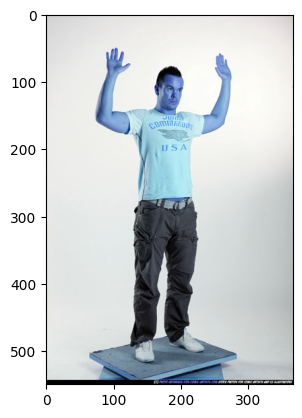

In [10]:
plt.imshow(img)

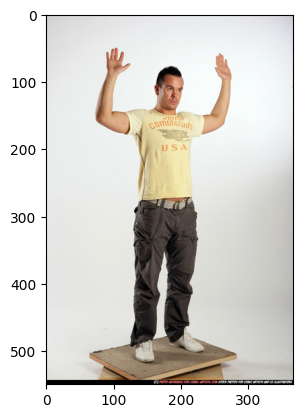

In [11]:
plt.imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB))

In [12]:
data = {
    "frame": [],
    "processing_time_ms": [],
    "detected_keypoints": [],
    "confidence_scores": []
}

In [13]:
image_filenames = [
    "data/pose.jpg", "data/pose1.jpg", "data/pose2.jpg", "data/pose3.jpg", "data/pose4.jpg", "data/posee.jpg"
]

In [14]:
# Define the yolo_pose_estimation function
def yolo_pose_estimation(image):
    model = torch.hub.load('ultralytics/yolov5', 'yolov5s')
    results = model(image)
    return results

In [ ]:
#The `classify_pose` function is designed to classify the pose of a person based on the detected keypoints 
# from a pose estimation model. It takes a list of keypoints as input and returns a description of the pose. 
# The function checks the positions of various body parts, such as shoulders, elbows, hips, knees, and ankles, 
# to determine specific poses like "Arms Outward", "Legs Straight", "T-Pose", "Squat", "Running", "Standing", and "Jumping". 
# This function can be extended by adding more conditions to classify additional poses or by refining the existing 
# conditions for better accuracy. To use this function, pass the detected keypoints from the pose estimation model to it, 
# and it will return a string describing the pose.

In [15]:
# Define the classify_pose function
def classify_pose(points):
    """Classify the pose based on keypoints for sports and fitness applications."""
    pose_description = []

    # Check arms position
    if points[BODY_PARTS["RShoulder"]] and points[BODY_PARTS["LShoulder"]] and \
       points[BODY_PARTS["RElbow"]] and points[BODY_PARTS["LElbow"]]:
        shoulder_distance = np.linalg.norm(np.array(points[BODY_PARTS["RShoulder"]]) - np.array(points[BODY_PARTS["LShoulder"]]))
        elbow_distance = np.linalg.norm(np.array(points[BODY_PARTS["RElbow"]]) - np.array(points[BODY_PARTS["LElbow"]]))

        if elbow_distance > shoulder_distance * 1.5:  # Arms stretched outward
            pose_description.append("Arms Outward")
        elif elbow_distance < shoulder_distance * 0.75:  # Arms close to body
            pose_description.append("Arms Neutral")
        else:
            pose_description.append("Arms Unknown")
    else:
        pose_description.append("Arms Unknown")

    # Check legs position
    if points[BODY_PARTS["RHip"]] and points[BODY_PARTS["LHip"]] and \
       points[BODY_PARTS["RKnee"]] and points[BODY_PARTS["LKnee"]]:
        hip_distance = np.linalg.norm(np.array(points[BODY_PARTS["RHip"]]) - np.array(points[BODY_PARTS["LHip"]]))
        right_leg_straight = points[BODY_PARTS["RKnee"]] and points[BODY_PARTS["RKnee"]][1] > points[BODY_PARTS["RHip"]][1] and \
                             points[BODY_PARTS["RAnkle"]] and points[BODY_PARTS["RAnkle"]][1] > points[BODY_PARTS["RKnee"]][1]
        left_leg_straight = points[BODY_PARTS["LKnee"]] and points[BODY_PARTS["LKnee"]][1] > points[BODY_PARTS["LHip"]][1] and \
                            points[BODY_PARTS["LAnkle"]] and points[BODY_PARTS["LAnkle"]][1] > points[BODY_PARTS["LKnee"]][1]

        if right_leg_straight and left_leg_straight:  # Both legs straight
            pose_description.append("Legs Straight")
        elif not right_leg_straight or not left_leg_straight:  # One or both legs bent
            pose_description.append("Legs Bent")
        else:
            pose_description.append("Legs Unknown")
    else:
        pose_description.append("Legs Unknown")

    # Check for specific sports and fitness poses
    if "Arms Outward" in pose_description and "Legs Straight" in pose_description:
        pose_description.append("T-Pose")
    if "Arms Neutral" in pose_description and "Legs Bent" in pose_description:
        pose_description.append("Squat")
    if points[BODY_PARTS["RShoulder"]] and points[BODY_PARTS["LShoulder"]] and \
       points[BODY_PARTS["RHip"]] and points[BODY_PARTS["LHip"]] and \
       points[BODY_PARTS["RKnee"]] and points[BODY_PARTS["LKnee"]]:
        if points[BODY_PARTS["RShoulder"]][1] < points[BODY_PARTS["RHip"]][1] and \
           points[BODY_PARTS["LShoulder"]][1] < points[BODY_PARTS["LHip"]][1] and \
           points[BODY_PARTS["RKnee"]][1] < points[BODY_PARTS["RHip"]][1] and \
           points[BODY_PARTS["LKnee"]][1] < points[BODY_PARTS["LHip"]][1]:
            pose_description.append("Jumping Jack")

    # Additional checks for sports and fitness applications
    if points[BODY_PARTS["RShoulder"]] and points[BODY_PARTS["LShoulder"]] and \
       points[BODY_PARTS["RHip"]] and points[BODY_PARTS["LHip"]]:
        if points[BODY_PARTS["RShoulder"]][1] < points[BODY_PARTS["RHip"]][1] and \
           points[BODY_PARTS["LShoulder"]][1] < points[BODY_PARTS["LHip"]][1]:
            if points[BODY_PARTS["RKnee"]] and points[BODY_PARTS["LKnee"]]:
                if points[BODY_PARTS["RKnee"]][1] < points[BODY_PARTS["RHip"]][1] and \
                   points[BODY_PARTS["LKnee"]][1] < points[BODY_PARTS["LHip"]][1]:
                    pose_description.append("Running")
                if points[BODY_PARTS["RKnee"]][1] > points[BODY_PARTS["RHip"]][1] and \
                   points[BODY_PARTS["LKnee"]][1] > points[BODY_PARTS["LHip"]][1]:
                    pose_description.append("Standing")

    if points[BODY_PARTS["RShoulder"]] and points[BODY_PARTS["LShoulder"]] and \
       points[BODY_PARTS["RHip"]] and points[BODY_PARTS["LHip"]] and \
       points[BODY_PARTS["RKnee"]] and points[BODY_PARTS["LKnee"]] and \
       points[BODY_PARTS["RAnkle"]] and points[BODY_PARTS["LAnkle"]]:
        if points[BODY_PARTS["RAnkle"]][1] < points[BODY_PARTS["RKnee"]][1] and \
           points[BODY_PARTS["LAnkle"]][1] < points[BODY_PARTS["LKnee"]][1]:
            pose_description.append("Jumping")

    # Check for general posture
    if points[BODY_PARTS["Neck"]] and points[BODY_PARTS["RHip"]] and points[BODY_PARTS["LHip"]]:
        neck = points[BODY_PARTS["Neck"]]
        rhip = points[BODY_PARTS["RHip"]]
        lhip = points[BODY_PARTS["LHip"]]

        if abs(neck[0] - rhip[0]) < 20 and abs(neck[0] - lhip[0]) < 20:
            pose_description.append("Standing Straight")
        elif neck[0] < rhip[0] and neck[0] < lhip[0]:
            pose_description.append("Leaning Left")
        elif neck[0] > rhip[0] and neck[0] > lhip[0]:
            pose_description.append("Leaning Right")

    # Check for sitting posture
    if points[BODY_PARTS["Neck"]] and points[BODY_PARTS["RHip"]] and points[BODY_PARTS["LHip"]]:
        if points[BODY_PARTS["Neck"]][1] > points[BODY_PARTS["RHip"]][1] and \
           points[BODY_PARTS["Neck"]][1] > points[BODY_PARTS["LHip"]][1]:
            pose_description.append("Sitting")

    # Combine pose descriptions
    return "Pose: " + ", ".join(pose_description)

In [ ]:
#The `pose_estimation` function uses the OpenPose model to estimate the pose of a person in a given frame. 
# It takes an image frame and a frame ID as input and returns the processed frame with the pose skeleton drawn on it and the pose label. 
# The function first checks if the required model files exist, then loads the OpenPose model. 
# It prepares the frame for pose estimation, performs the forward pass to get the keypoints, and classifies the pose based on the detected keypoints. 
# The skeleton lines and points are drawn on the frame, and performance profiling data is collected. 
# This function can be extended by adding more pose classifications or refining the existing ones.

In [16]:
# Define the pose_estimation function using OpenPose
def pose_estimation(frame, frame_id):
    protoFile = "pose_deploy_linevec.prototxt"
    weightsFile = "pose_iter_440000.caffemodel"

    # Check if the model files exist
    if not os.path.isfile(protoFile) or not os.path.isfile(weightsFile):
        raise FileNotFoundError("Model files not found. Please ensure 'pose_deploy_linevec.prototxt' and 'pose_iter_440000.caffemodel' are in the working directory.")

    net = cv.dnn.readNetFromCaffe(protoFile, weightsFile)

    frameWidth = frame.shape[1]
    frameHeight = frame.shape[0]

    # Start timing
    start_time = time.time()

    # Prepare the frame for pose estimation
    inpBlob = cv.dnn.blobFromImage(frame, 1.0 / 255, (368, 368), (0, 0, 0), swapRB=False, crop=False)
    net.setInput(inpBlob)
    output = net.forward()

    H = output.shape[2]
    W = output.shape[3]

    # Extract keypoints and confidence scores
    points = []
    detected_keypoints = 0
    confidence_scores = []

    for i in range(len(BODY_PARTS)):
        heatMap = output[0, i, :, :]
        _, conf, _, point = cv.minMaxLoc(heatMap)
        x = (frameWidth * point[0]) / W
        y = (frameHeight * point[1]) / H

        # Add a point if its confidence is higher than threshold.
        if conf > 0.1:  # Assuming a threshold value
            detected_keypoints += 1
            confidence_scores.append(conf)
            points.append((int(x), int(y)))
        else:
            points.append(None)

    # Classify the pose
    pose_label = classify_pose(points)

    # Draw the skeleton lines and points
    for pair in POSE_PAIRS:
        partFrom = pair[0]
        partTo = pair[1]
        assert(partFrom in BODY_PARTS)
        assert(partTo in BODY_PARTS)

        idFrom = BODY_PARTS[partFrom]
        idTo = BODY_PARTS[partTo]

        if points[idFrom] and points[idTo]:
            cv.line(frame, points[idFrom], points[idTo], (0, 255, 0), 3)
            cv.ellipse(frame, points[idFrom], (3, 3), 0, 0, 360, (0, 0, 255), cv.FILLED)
            cv.ellipse(frame, points[idTo], (3, 3), 0, 0, 360, (0, 0, 255), cv.FILLED)

    # Performance profiling
    processing_time = (time.time() - start_time) * 1000  # Processing time in ms

    # Save data for this frame
    data["frame"].append(frame_id)
    data["processing_time_ms"].append(processing_time)
    data["detected_keypoints"].append(detected_keypoints)
    data["confidence_scores"].append(confidence_scores)

    return frame, pose_label

In [ ]:
#The following code processes a list of images to perform pose estimation using the YOLO and OpenPose models. 
# It loads each image, performs pose estimation, and saves the results with a title indicating the detected pose. 
# The processed images are saved in the specified output directory, and the data collected during processing is saved to a CSV file. 
# This code can be extended by adding more images to the list or modifying the pose estimation function to include additional pose classifications.

In [18]:
# Process all images
output_dir = "output"
os.makedirs(output_dir, exist_ok=True)

for idx, image_filename in enumerate(image_filenames, 1):
    # Load the image
    img = cv.imread(image_filename)
    
    if img is None:
        print(f"Error: Unable to load image {image_filename}")
        continue

    # Process the frame
    estimated_image, pose_label = pose_estimation(img, idx)

    # Save the result with title
    plt.figure(figsize=(10, 6))
    plt.imshow(cv.cvtColor(estimated_image, cv.COLOR_BGR2RGB))
    plt.title(pose_label)
    plt.axis('off')
    output_filename = os.path.join(output_dir, f"pose_estimation_{idx}.png")
    plt.savefig(output_filename, bbox_inches='tight', pad_inches=0.1)
    plt.close()
    print(f"Saved: {output_filename}")

# After processing all frames, save the data to CSV
data_df = pd.DataFrame(data)
data_df.to_csv("pose_data.csv", index=False)
print("Data saved to pose_data.csv")

Saved: output\pose_estimation_1.png
Saved: output\pose_estimation_2.png
Saved: output\pose_estimation_3.png
Saved: output\pose_estimation_4.png
Saved: output\pose_estimation_5.png
Saved: output\pose_estimation_6.png
Data saved to pose_data.csv


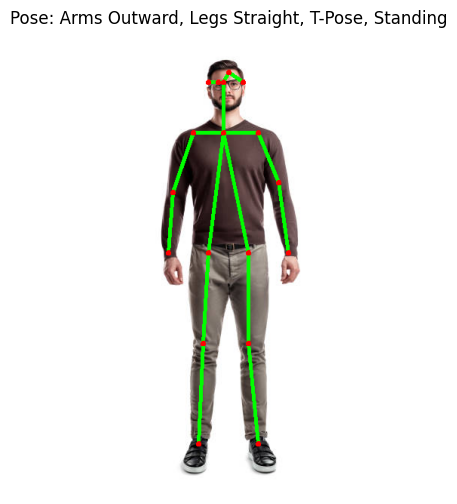

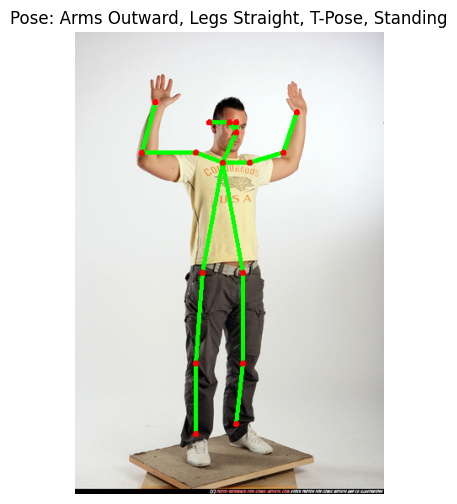

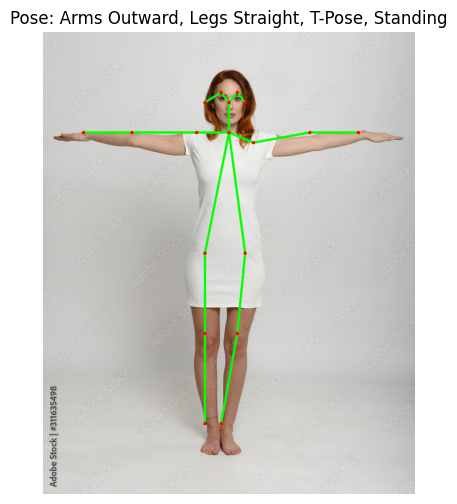

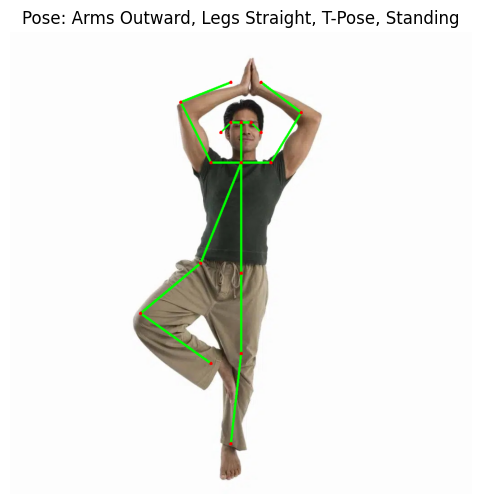

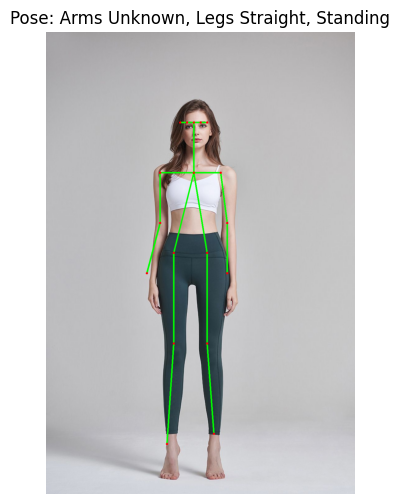

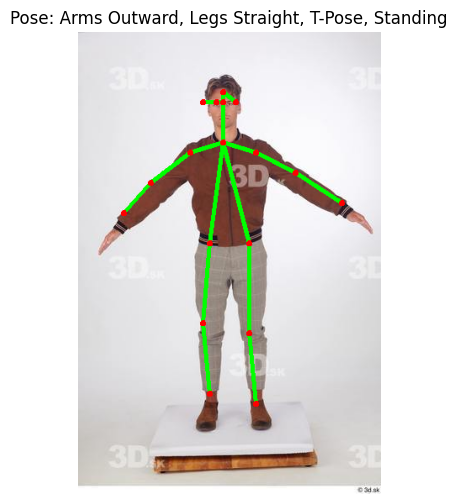

In [ ]:
from IPython.display import Image, display
import os

def display_saved_images(output_dir="output"):
    for filename in sorted(os.listdir(output_dir)):
        if filename.endswith(".png"):
            display(Image(filename=os.path.join(output_dir, filename)))

# call image display funciton
display_saved_images()

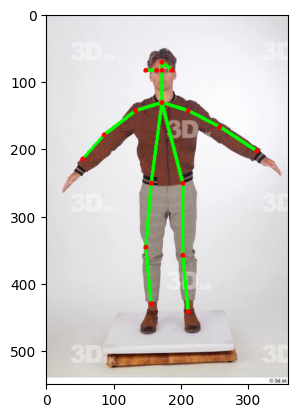

In [14]:
plt.imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB))

In [44]:
#Video

#This code performs real-time pose estimation on a video using OpenCV’s DNN (Deep Neural Network) module with a pre-trained TensorFlow model. 
#It starts by attempting to open a video file (pose_estimation_video.mp4), and if unsuccessful, it defaults to capturing video from the system's webcam. 
#The video feed is processed frame by frame in a loop, where each frame is converted into a blob format suitable for the neural network using cv.dnn.blobFromImage(). 
#The pre-trained model performs a forward pass on the frame, generating keypoints for different body parts. 
#These keypoints are extracted based on confidence values, and if they meet the threshold, they are added to a list. 
#Lines are drawn between connected keypoints to form a skeleton, and ellipses are placed at the keypoint locations to visualize the detected body parts. 
#Additionally, the code measures the time taken to process each frame and displays it in milliseconds on the video feed. 
#Finally, the processed video frames with the overlaid skeleton are displayed in real-time using cv.imshow().


In [27]:
# Perform this demo on a video
cap = cv.VideoCapture('data/pose_estimation_video.mp4')
cap.set(3, 800)  # Set height
cap.set(4, 800)  # Set width

if not cap.isOpened():
    cap = cv.VideoCapture(0)
if not cap.isOpened():
    raise IOError("Cannot open video")

# Initialize data collection for analytics
data = {
    "frame": [],
    "processing_time_ms": [],
    "detected_keypoints": [],
    "confidence_scores": []
}

frame_id = 0

while cv.waitKey(1) < 0:
    hasFrame, frame = cap.read()
    if not hasFrame:
        cv.waitKey()
        break

    frame_id += 1
    frameWidth = frame.shape[1]
    frameHeight = frame.shape[0]

    # Start timing
    start_time = time.time()

    # Perform pose estimation
    net.setInput(cv.dnn.blobFromImage(frame, 1.0, (inWidth, inHeight), (127.5, 127.5, 127.5), swapRB=True, crop=False))
    out = net.forward()
    out = out[:, :19, :, :]

    assert(len(BODY_PARTS) == out.shape[1])

    points = []
    detected_keypoints = 0
    confidence_scores = []

    for i in range(len(BODY_PARTS)):
        heatMap = out[0, i, :, :]
        _, conf, _, point = cv.minMaxLoc(heatMap)
        x = (frameWidth * point[0]) / out.shape[3]
        y = (frameHeight * point[1]) / out.shape[2]

        # Add a point if its confidence is higher than threshold
        if conf > thr:
            detected_keypoints += 1
            confidence_scores.append(conf)
            points.append((int(x), int(y)))
        else:
            points.append(None)

    # Draw the skeleton lines and points
    for pair in POSE_PAIRS:
        partFrom = pair[0]
        partTo = pair[1]
        assert(partFrom in BODY_PARTS)
        assert(partTo in BODY_PARTS)

        idFrom = BODY_PARTS[partFrom]
        idTo = BODY_PARTS[partTo]

        if points[idFrom] and points[idTo]:
            cv.line(frame, points[idFrom], points[idTo], (0, 255, 0), 3)
            cv.ellipse(frame, points[idFrom], (3, 3), 0, 0, 360, (0, 0, 255), cv.FILLED)
            cv.ellipse(frame, points[idTo], (3, 3), 0, 0, 360, (0, 0, 255), cv.FILLED)

    # End timing
    processing_time = (time.time() - start_time) * 1000  # Processing time in ms

    # Save analytics data for this frame
    data["frame"].append(frame_id)
    data["processing_time_ms"].append(processing_time)
    data["detected_keypoints"].append(detected_keypoints)
    data["confidence_scores"].append(confidence_scores)

    # Display processing time on the frame
    cv.putText(frame, '%.2fms' % processing_time, (10, 20), cv.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0))

    # Show the frame
    cv.imshow('Pose Estimation Tutorial', frame)

# Save the collected data to a CSV file
data_df = pd.DataFrame(data)
data_df.to_csv("video_pose_data.csv", index=False)
print("Data saved to video_pose_data.csv")


Data saved to video_pose_data.csv


In [62]:
#This code performs real-time pose estimation using a webcam feed with OpenCV’s DNN module and a pre-trained TensorFlow model. 
#The script first attempts to open the camera feed from the secondary webcam (cv.VideoCapture(1)), and if this fails, it defaults to the primary camera (cv.VideoCapture(0)). 
#If no camera is available, an error is raised. The video feed is processed frame by frame in a loop. 
#For each frame, the image dimensions are obtained, and the frame is converted into a blob suitable for neural network input using cv.dnn.blobFromImage(). 
#The pose estimation model performs a forward pass on the frame, and keypoints for various body parts are extracted based on confidence scores. 
#These keypoints are stored and, if they meet a threshold, connected to form a skeleton using lines and ellipses. 
#The code also calculates and displays the inference time in milliseconds on the video frame. 
#The processed video with the overlaid skeleton is displayed in real-time using cv.imshow(). The loop runs until a key is pressed or the video feed is interrupted.

In [63]:
#camera
#perform this demo on video
#from google.colab.patches import cv2_imshow
cap = cv.VideoCapture(1)
cap.set(3,800) #height
cap.set(4,800) #width

if not cap.isOpened():
    cap = cv.VideoCapture(0)
if not cap.isOpened():
    raise IOError("Cannot open webcam")

while cv.waitKey(1) < 0:
    hasFrame,frame = cap.read()
    if not hasFrame:
        cv.waitKey()
        break
        
    frameWidth = frame.shape[1]
    frameHeight = frame.shape[0]
    net.setInput(cv.dnn.blobFromImage(frame, 1.0, (inWidth, inHeight), (127.5, 127.5, 127.5), swapRB=True, crop=False))
    out = net.forward()
    out = out[:, :19, :, :]

    assert(len(BODY_PARTS) == out.shape[1])

    points = []

    for i in range(len(BODY_PARTS)):
        heatMap = out[0, i, :, :]
        _, conf, _, point = cv.minMaxLoc(heatMap)
        print(f"Body part {i}: Confidence = {conf}, Point = {point}")
        x = (frameWidth * point[0]) / out.shape[3]
        y = (frameHeight * point[1]) / out.shape[2]

        # Add a point if it's confidence is higher than threshold.
        points.append((int(x), int(y)) if conf > thr else None)

    for pair in POSE_PAIRS:
        partFrom = pair[0]
        partTo = pair[1]
        assert(partFrom in BODY_PARTS)
        assert(partTo in BODY_PARTS)

        idFrom = BODY_PARTS[partFrom]
        idTo = BODY_PARTS[partTo]

        if points[idFrom] and points[idTo]:
            cv.line(frame, points[idFrom], points[idTo], (0, 255, 0), 3)
            cv.ellipse(frame, points[idFrom], (3, 3), 0, 0, 360, (0, 0, 255), cv.FILLED)
            cv.ellipse(frame, points[idTo], (3, 3), 0, 0, 360, (0, 0, 255), cv.FILLED)

    t, _ = net.getPerfProfile()
    freq = cv.getTickFrequency() / 1000
    cv.putText(frame, '%.2fms' % (t / freq), (10, 20), cv.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0))

    cv.imshow('Pose Estimation Tutorial', frame)
    
        

Body part 0: Confidence = 0.005596462171524763, Point = (44, 2)
Body part 1: Confidence = 0.01110764592885971, Point = (44, 1)
Body part 2: Confidence = 0.011710772290825844, Point = (43, 0)
Body part 3: Confidence = 0.011356491595506668, Point = (45, 0)
Body part 4: Confidence = 0.0048688240349292755, Point = (0, 0)
Body part 5: Confidence = 0.007924281060695648, Point = (22, 10)
Body part 6: Confidence = 0.01031801663339138, Point = (43, 45)
Body part 7: Confidence = 0.008425211533904076, Point = (43, 1)
Body part 8: Confidence = 0.0066382549703121185, Point = (24, 23)
Body part 9: Confidence = 0.00800841674208641, Point = (22, 8)
Body part 10: Confidence = 0.003647059202194214, Point = (43, 2)
Body part 11: Confidence = 0.010167999193072319, Point = (45, 0)
Body part 12: Confidence = 0.0116965277120471, Point = (23, 9)
Body part 13: Confidence = 0.006961318664252758, Point = (45, 2)
Body part 14: Confidence = 0.00771213136613369, Point = (44, 45)
Body part 15: Confidence = 0.0068599

In [59]:
import cv2 as cv
import numpy as np

# Load the pre-trained neural network model
net = cv.dnn.readNetFromTensorflow("graph_opt.pb") 

# Set the input size for the network
inWidth = 368
inHeight = 368
thr = 0.2  

# Define the BODY_PARTS and POSE_PAIRS
BODY_PARTS = {0: "Nose", 1: "Neck", 2: "RShoulder", 3: "RElbow", 4: "RWrist",
              5: "LShoulder", 6: "LElbow", 7: "LWrist", 8: "RHip", 9: "RKnee",
              10: "RAnkle", 11: "LHip", 12: "LKnee", 13: "LAnkle", 14: "REye",
              15: "LEye", 16: "REar", 17: "LEar", 18: "Background"}

POSE_PAIRS = [["Neck", "RShoulder"], ["Neck", "LShoulder"], ["RShoulder", "RElbow"],
              ["RElbow", "RWrist"], ["LShoulder", "LElbow"], ["LElbow", "LWrist"],
              ["Neck", "RHip"], ["RHip", "RKnee"], ["RKnee", "RAnkle"],
              ["Neck", "LHip"], ["LHip", "LKnee"], ["LKnee", "LAnkle"],
              ["Neck", "Nose"], ["Nose", "REye"], ["REye", "REar"],
              ["Nose", "LEye"], ["LEye", "LEar"]]

# Define the pose_estimation function
def pose_estimation(frame):
    frameWidth = frame.shape[1]
    frameHeight = frame.shape[0]
    net.setInput(cv.dnn.blobFromImage(frame, 1.0, (inWidth, inHeight), (127.5, 127.5, 127.5), swapRB=True, crop=False))
    out = net.forward()
    out = out[:, :19, :, :]

    assert(len(BODY_PARTS) == out.shape[1])

    points = []

    for i in range(len(BODY_PARTS)):
        heatMap = out[0, i, :, :]
        _, conf, _, point = cv.minMaxLoc(heatMap)
        x = (frameWidth * point[0]) / out.shape[3]
        y = (frameHeight * point[1]) / out.shape[2]

        points.append((int(x), int(y)) if conf > thr else None)

    return points

# Function to calculate the Euclidean distance between two points
def euclidean_distance(point1, point2):
    return np.linalg.norm(np.array(point1) - np.array(point2))

# Function to calculate the similarity percentage between two sets of keypoints
def calculate_similarity_percentage(keypoints1, keypoints2, max_distance=200):
    if len(keypoints1) != len(keypoints2):
        raise ValueError("Keypoints from both images must have the same length.")
    
    total_distance = 0
    valid_points = 0

    for kp1, kp2 in zip(keypoints1, keypoints2):
        if kp1 is not None and kp2 is not None:
            total_distance += euclidean_distance(kp1, kp2)
            valid_points += 1

    if valid_points == 0:
        return 0  # No valid points to compare

    average_distance = total_distance / valid_points
    similarity_percentage = max(0, 100 * (1 - average_distance / max_distance))
    
    return similarity_percentage

# Load the first image and extract keypoints
img = cv.imread("pose2.jpg")
keypoints_img1 = pose_estimation(img)

# Load the second image and extract keypoints
img2 = cv.imread("pose.jpg")
keypoints_img2 = pose_estimation(img2)

# Calculate the similarity percentage between the two sets of keypoints
similarity_percentage = calculate_similarity_percentage(keypoints_img1, keypoints_img2)

print(f"The similarity between the two poses is {similarity_percentage:.2f}%")


AttributeError: 'NoneType' object has no attribute 'shape'

In [ ]:
#This code performs pose estimation and matching on two images using OpenCV’s DNN module with a pre-trained TensorFlow model. 
#The pose_estimation function extracts keypoints for 18 body parts (like the nose, shoulders, and hips) from each image, and visualizes them by drawing skeletons using lines and ellipses. 
#The keypoints from both images are compared using Euclidean distance, and the calculate_similarity_percentage function calculates a similarity score between the two poses. 
#The images are resized to the same height for comparison, and the two skeleton-overlaid images are combined side by side. 
#The similarity percentage is displayed on the combined image, which is then shown using Matplotlib. 
#This allows for both a visual and quantitative assessment of how closely the two poses match.

In [60]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

# Load the pre-trained neural network model
net = cv.dnn.readNetFromTensorflow("graph_opt.pb")

# Set the input size for the network
inWidth = 368
inHeight = 368
thr = 0.2

# Define the BODY_PARTS with names as keys
BODY_PARTS = {"Nose": 0, "Neck": 1, "RShoulder": 2, "RElbow": 3, "RWrist": 4,
              "LShoulder": 5, "LElbow": 6, "LWrist": 7, "RHip": 8, "RKnee": 9,
              "RAnkle": 10, "LHip": 11, "LKnee": 12, "LAnkle": 13, "REye": 14,
              "LEye": 15, "REar": 16, "LEar": 17, "Background": 18}

POSE_PAIRS = [["Neck", "RShoulder"], ["Neck", "LShoulder"], ["RShoulder", "RElbow"],
              ["RElbow", "RWrist"], ["LShoulder", "LElbow"], ["LElbow", "LWrist"],
              ["Neck", "RHip"], ["RHip", "RKnee"], ["RKnee", "RAnkle"],
              ["Neck", "LHip"], ["LHip", "LKnee"], ["LKnee", "LAnkle"],
              ["Neck", "Nose"], ["Nose", "REye"], ["REye", "REar"],
              ["Nose", "LEye"], ["LEye", "LEar"]]

# Pose estimation function with skeleton drawing
def pose_estimation(frame):
    if frame is None:
        raise ValueError("The image could not be loaded. Please check the file path.")
    
    frameWidth = frame.shape[1]
    frameHeight = frame.shape[0]
    net.setInput(cv.dnn.blobFromImage(frame, 1.0, (inWidth, inHeight), (127.5, 127.5, 127.5), swapRB=True, crop=False))
    out = net.forward()
    out = out[:, :19, :, :]

    assert(len(BODY_PARTS) == out.shape[1])

    points = []

    for i in range(len(BODY_PARTS)):
        heatMap = out[0, i, :, :]
        _, conf, _, point = cv.minMaxLoc(heatMap)
        x = (frameWidth * point[0]) / out.shape[3]
        y = (frameHeight * point[1]) / out.shape[2]
        
        # Only consider points with confidence above threshold
        points.append((int(x), int(y)) if conf > thr else None)

    # Draw skeleton
    for pair in POSE_PAIRS:
        partFrom = pair[0]
        partTo = pair[1]

        idFrom = BODY_PARTS[partFrom]
        idTo = BODY_PARTS[partTo]

        if points[idFrom] and points[idTo]:
            cv.line(frame, points[idFrom], points[idTo], (0, 255, 0), 3)
            cv.ellipse(frame, points[idFrom], (3, 3), 0, 0, 360, (0, 0, 255), cv.FILLED)
            cv.ellipse(frame, points[idTo], (3, 3), 0, 0, 360, (0, 0, 255), cv.FILLED)

    return points, frame

# Function to calculate Euclidean distance between two points
def euclidean_distance(point1, point2):
    return np.linalg.norm(np.array(point1) - np.array(point2))

# Function to calculate similarity percentage between two sets of keypoints
def calculate_similarity_percentage(keypoints1, keypoints2, max_distance=200):
    total_distance = 0
    valid_points = 0

    for kp1, kp2 in zip(keypoints1, keypoints2):
        if kp1 is not None and kp2 is not None:
            total_distance += euclidean_distance(kp1, kp2)
            valid_points += 1

    if valid_points == 0:
        return 0  # No valid points to compare

    average_distance = total_distance / valid_points
    similarity_percentage = max(0, 100 * (1 - average_distance / max_distance))
    
    return similarity_percentage

# Function to resize images to the same height
def resize_to_same_height(img1, img2):
    height1 = img1.shape[0]
    height2 = img2.shape[0]

    if height1 != height2:
        # Resize the second image to match the first image's height
        img2 = cv.resize(img2, (int(img2.shape[1] * (height1 / height2)), height1))

    return img1, img2

# Load and process the first image
img1 = cv.imread("pose4.jpg")
if img1 is None:
    print("Error loading pose4.jpg")

keypoints_img1, img1_with_pose = pose_estimation(img1)

# Load and process the second image
img2 = cv.imread("pose4.jpg")  # Changed file to "pose2.jpg" for comparison
if img2 is None:
    print("Error loading pose2.jpg")

keypoints_img2, img2_with_pose = pose_estimation(img2)

# Resize images to have the same height
img1_with_pose, img2_with_pose = resize_to_same_height(img1_with_pose, img2_with_pose)

# Calculate the similarity percentage between the two poses
similarity_percentage = calculate_similarity_percentage(keypoints_img1, keypoints_img2)

# Combine both images side by side
combined_image = np.hstack((img1_with_pose, img2_with_pose))

# Add similarity percentage text to the combined image
cv.putText(combined_image, f"Similarity: {similarity_percentage:.2f}%", (10, 30),
           cv.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2)

# Convert BGR to RGB for matplotlib
combined_image_rgb = cv.cvtColor(combined_image, cv.COLOR_BGR2RGB)

# Display the combined image using matplotlib
plt.figure(figsize=(10, 6))
plt.imshow(combined_image_rgb)
plt.title(f"Pose Estimation and Matching (Similarity: {similarity_percentage:.2f}%)")
plt.axis("off")  # Hide the axis
plt.show()


Error loading pose4.jpg


ValueError: The image could not be loaded. Please check the file path.